In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/summer2winter_yosemite/winter/winter/2016-03-22 16:19:04.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2009-05-13 15:01:35.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2013-03-21 17:02:55.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2013-03-07 20:49:39.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2011-01-11 19:21:46.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2013-12-18 18:40:33.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2007-04-30 20:41:22.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2012-02-09 05:02:07.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2013-02-02 06:36:13.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2016-06-03 03:10:42.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2011-01-08 11:57:43.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2010-12-15 18:32:44.jpg
/kaggle/input/summer2winter_yosemite/winter/winter/2013-05-22 03:31:55.jpg
/kaggle/input/summer2wint

/kaggle/input/summer2winter_yosemite/summer/summer/2014-08-26 03:23:49.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2015-09-02 23:25:58.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2011-08-19 10:33:38.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2016-09-06 18:32:34.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2011-06-27 10:59:38.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2013-01-05 03:00:52.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2013-08-24 19:50:24.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2014-07-30 22:20:53.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2015-06-29 03:42:43.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2011-06-15 22:42:27.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2011-08-08 06:19:46.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2015-06-17 18:20:47.jpg
/kaggle/input/summer2winter_yosemite/summer/summer/2016-08-18 08:51:23.jpg
/kaggle/input/summer2wint

In [2]:
# Loading and transforming data
import torch 
import torchvision 
from torchvision import datasets, transforms 

# Visualizing data
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline 


In [3]:
import os 

def get_data_loader(image_type, image_dir = '/kaggle/input/summer2winter_yosemite/', image_size=128, batch_size=16):

    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    train_path = os.path.join(image_dir, image_type)
    test_path = os.path.join(image_dir, 'test_{}'.format(image_type))
    
    traindata = datasets.ImageFolder(train_path, transform=transform)
    testdata = datasets.ImageFolder(test_path, transform=transform)
    
    trainloader = torch.utils.data.DataLoader(traindata, shuffle=False, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(testdata, shuffle=False, batch_size=batch_size)
    
    return trainloader, testloader
    
X_trainloader, X_testloader = get_data_loader(image_type='summer')
Y_trainloader, Y_testloader = get_data_loader(image_type='winter')

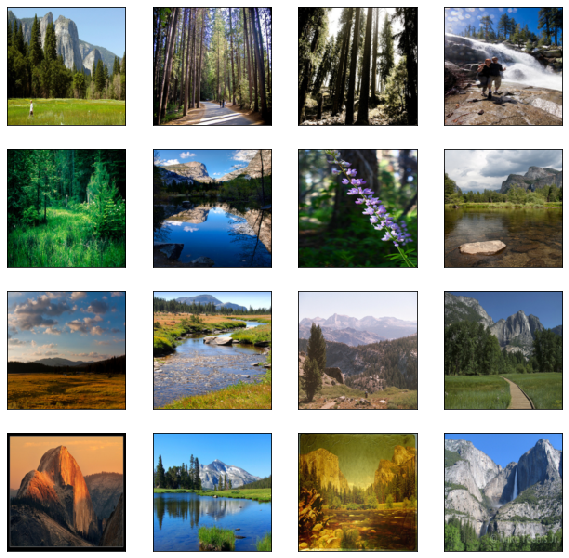

In [7]:
def imshow(img, ax):
    img = img/2 + 0.5
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
images, _ = next(iter(X_trainloader))

for ax, img in zip(axes.flatten(), images):
    imshow(img, ax)

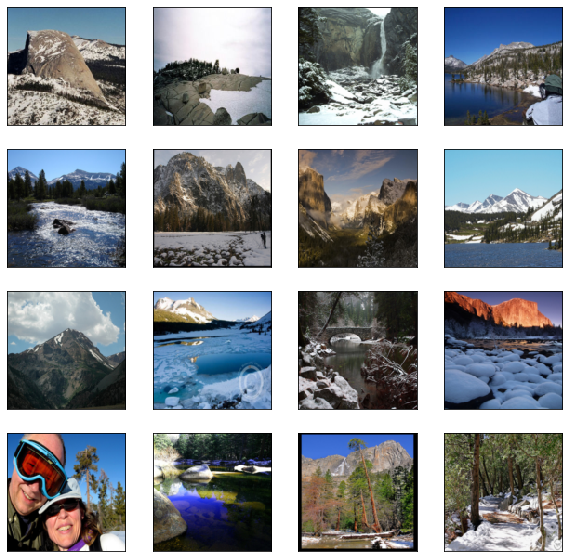

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
images, _ = next(iter(Y_trainloader))

for ax, img in zip(axes.flatten(), images):
    imshow(img, ax)

In [9]:
import torch.nn as nn 
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """ Creates a convolutional layer, with optional batch normalization"""
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64):
        super().__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

D_X = Discriminator()
D_Y = Discriminator()
print(D_X)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)


In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, conv_dim):
        super().__init__()
        self.conv1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                          kernel_size=3, stride=1, padding=1, batch_norm=True)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                          kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x = x + self.conv2(x1)
        return x

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [13]:
class CycleGenerator(nn.Module):
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super().__init__()
        # 1. Define the encoder part of the generator
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 2. Define the resnet part of the generator
        res_layers = []
        for _ in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        self.res_blocks = nn.Sequential(*res_layers)
        # 3. Define the decoder part of the generator
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # RESIDUAL NET 
        x = self.res_blocks(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        return x 

In [14]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    GX_Y = CycleGenerator(g_conv_dim).to(device)
    GY_X = CycleGenerator(g_conv_dim).to(device)
    D_X = Discriminator(d_conv_dim).to(device)
    D_Y = Discriminator(d_conv_dim).to(device)
    if torch.cuda.is_available():
        print("Model moved to GPU.")
    else:
        print("Only CPU is available.")
    return GX_Y, GY_X, D_X, D_Y

GX_Y, GY_X, D_X, D_Y = create_model()

Model moved to GPU.


In [ ]:
# def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
#     """Builds the generators and discriminators."""
    
#     # Instantiate generators
#     GX_Y = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
#     GY_X = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
#     # Instantiate discriminators
#     D_X = Discriminator(conv_dim=d_conv_dim)
#     D_Y = Discriminator(conv_dim=d_conv_dim)

#     # move models to GPU, if available
#     if torch.cuda.is_available():
#         device = torch.device("cuda:0")
#         GX_Y.to(device)
#         GY_X.to(device)
#         D_X.to(device)
#         D_Y.to(device)
#         print('Models moved to GPU.')
#     else:
#         print('Only CPU available.')

#     return GX_Y, GY_X, D_X, D_Y

# GX_Y, GY_X, D_X, D_Y = create_model()

In [15]:
def print_model(GX_Y, GY_X, D_X, D_Y):
    print("------------------------GENARATOR X TO Y --------------------------------")
    print(GX_Y)
    print()
    print("------------------------GENARATOR Y TO X --------------------------------")
    print(GY_X)
    print()
    print("------------------------DISCRIMINATOR X  --------------------------------")
    print(D_X)
    print()
    print("------------------------DISCRIMINATOR Y  --------------------------------")
    print(D_Y)
    print()

print_model(GX_Y, GY_X, D_X, D_Y)

------------------------GENARATOR X TO Y --------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Sequenti

In [16]:
# Define loss 
def real_mse_loss(D_out):
    # how close is the produced output from being "real"
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_img, reconstr_img, lambda_weight=10):
    # calculate reconstruction loss 
    # as absolute value diffrence between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_img - reconstr_img))
    return lambda_weight*reconstr_loss

In [17]:
# Define the optimizers
import torch.optim as optim 

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

G_params = list(GX_Y.parameters()) + list(GY_X.parameters())

G_optimizer = optim.Adam(G_params, lr=lr, betas=(beta1, beta2))
D_X_optimizer = optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
D_Y_optimizer = optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))

In [18]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=1000):
    
    losses = []
    print_every = 10
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    
    dataiter_X = iter(dataloader_X)
    dataiter_Y = iter(dataloader_Y)
    
    batches_per_epoch = min(len(dataiter_X), len(dataiter_Y))
    
    for epoch in range(1, n_epochs):
        
        if epoch % batches_per_epoch == 0:
            dataiter_X, dataiter_Y = iter(dataloader_X), iter(dataloader_Y)
        
        images_X, _ = next(dataiter_X)
        images_Y, _ = next(dataiter_Y)
        
        images_X, images_Y = images_X.to(device), images_Y.to(device)
        #########################################################
        #                TRAIN DISCRIMINATOR                    #
        #########################################################
        
        D_X_optimizer.zero_grad()
        out_X = D_X(images_X)
        # 1. Compute the discriminator loss on real images
        D_X_real_loss = real_mse_loss(out_X)
        # 2. Generator fake images that look like domain X based on real images in domain Y
        fake_X_images = GY_X(images_Y)
        # 3. Compute the discriminator loss on fake images
        out_X = D_X(fake_X_images)
        D_X_fake_loss = fake_mse_loss(out_X)
        # 4. Compute the total loss and perform backpropagation and DX optimization
        D_X_loss = D_X_real_loss + D_X_fake_loss
        D_X_loss.backward()
        D_X_optimizer.step()
        
        # SWITCH
        D_Y_optimizer.zero_grad()
        out_Y = D_Y(images_Y)
        # 1. Compute the discriminator loss on real images
        D_Y_real_loss = real_mse_loss(out_Y)
        # 2. Generator fake images that look like domain Y based on real images in domain X
        fake_Y_images = GX_Y(images_X)
        out_Y = D_Y(fake_Y_images)
        # 3. Compute the discriminator loss on fake images
        D_Y_fake_loss = fake_mse_loss(out_Y)
        # 4. Compute the total loss and perform backpropagation and DY optimization
        D_Y_loss = D_Y_real_loss + D_Y_fake_loss
        D_Y_loss.backward()
        D_Y_optimizer.step()
        
        #########################################################
        #                    TRAIN GENERATOR                    #
        #########################################################
        
        G_optimizer.zero_grad()
        # 1. Generator fake images that look like domain X based on real images in domain Y
        fake_X_images = GY_X(images_Y)
        # 2. Compute the generator loss based on how DX responds to fake X
        out_X = D_X(fake_X_images)
        G_X_loss = real_mse_loss(out_X)
        # 3. Generate reconstructed Y hat images based on the fake X images generated in step 1
        constr_Y_images = GX_Y(fake_X_images)
        # 4. Compute the cycle consistency loss by comparing the reconstructions with real Y images
        G_Y_constr_loss = cycle_consistency_loss(images_Y, constr_Y_images)
        
        # SWITCH 

        # 1. Generator fake images that look like domain Y based on real images in domain X
        fake_Y_images = GX_Y(images_X)
        # 2. Compute the generator loss based on how DY responds to fake Y 
        out_Y = D_Y(fake_Y_images)
        G_Y_loss = real_mse_loss(out_Y)
        # 3. Generate reconstructed X hat images based on the fake Y images generated in step 1
        constr_X_images = GY_X(fake_Y_images)
        # 4. Compute the cycle consistency loss by comparing the reconstructions with real X images 
        G_X_constr_loss = cycle_consistency_loss(images_X, constr_X_images)
        
        # 5. Add up all generator and reconstruction losses and perform backpropagation + optimization 
        G_loss = G_X_loss + G_Y_constr_loss + G_Y_loss + G_X_constr_loss
        G_loss.backward()
        G_optimizer.step()
        
        if epoch % print_every == 0:
            losses.append((D_X_loss.item(), D_Y_loss.item(), G_loss.item()))
            print("Epoch [{:4d}/{:4d}] | D_X_loss : {:6.4f} | D_Y_loss : {:6.4f} | G_total_loss : {:6.4f}.".format(
                epoch, n_epochs, D_X_loss.item(), D_Y_loss.item(), G_loss.item()))
    
#         sample_every = 1000
#         if epoch % sample_every == 0
#             GX_Y.eval()
#             GY_X.eval()
#             save_samples(epoch, fixed_X, fixed_Y, GY_X, GX_Y, batch_size=16)
#             GX_Y.train()
#             GY_X.train()
        
#         checkpoint_every = 1000
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, GX_Y, GY_X, D_X, D_Y)
    return losses

In [19]:
n_epochs = 4000

losses = training_loop(X_trainloader, Y_trainloader, X_testloader, Y_testloader, n_epochs)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [  10/4000] | D_X_loss : 0.3986 | D_Y_loss : 0.3405 | G_total_loss : 10.2556.
Epoch [  20/4000] | D_X_loss : 1.0147 | D_Y_loss : 0.5371 | G_total_loss : 7.9242.
Epoch [  30/4000] | D_X_loss : 0.2694 | D_Y_loss : 0.3944 | G_total_loss : 7.0672.
Epoch [  40/4000] | D_X_loss : 0.7999 | D_Y_loss : 0.2428 | G_total_loss : 7.7224.
Epoch [  50/4000] | D_X_loss : 0.5542 | D_Y_loss : 0.3204 | G_total_loss : 5.0531.
Epoch [  60/4000] | D_X_loss : 0.4509 | D_Y_loss : 0.2675 | G_total_loss : 5.8012.
Epoch [  70/4000] | D_X_loss : 0.3850 | D_Y_loss : 0.8036 | G_total_loss : 4.6806.
Epoch [  80/4000] | D_X_loss : 0.5056 | D_Y_loss : 0.4389 | G_total_loss : 5.6687.
Epoch [  90/4000] | D_X_loss : 0.3419 | D_Y_loss : 0.4014 | G_total_loss : 5.0914.
Epoch [ 100/4000] | D_X_loss : 0.5037 | D_Y_loss : 0.5665 | G_total_loss : 5.9686.
Epoch [ 110/4000] | D_X_loss : 0.4801 | D_Y_loss : 0.3227 | G_total_loss : 5.1720.
Epoch [ 120/4000] | D_X_loss : 0.5886 | D_Y_loss : 0.2686 | G_total_loss : 5.1161.
Epo

Epoch [1000/4000] | D_X_loss : 0.3375 | D_Y_loss : 0.2120 | G_total_loss : 3.9518.
Epoch [1010/4000] | D_X_loss : 0.5412 | D_Y_loss : 0.4509 | G_total_loss : 4.7086.
Epoch [1020/4000] | D_X_loss : 0.3153 | D_Y_loss : 0.3715 | G_total_loss : 4.1647.
Epoch [1030/4000] | D_X_loss : 0.4539 | D_Y_loss : 0.2789 | G_total_loss : 3.7789.
Epoch [1040/4000] | D_X_loss : 0.3682 | D_Y_loss : 0.3542 | G_total_loss : 3.8758.
Epoch [1050/4000] | D_X_loss : 0.3426 | D_Y_loss : 0.4149 | G_total_loss : 4.5509.
Epoch [1060/4000] | D_X_loss : 0.2706 | D_Y_loss : 0.3977 | G_total_loss : 4.7077.
Epoch [1070/4000] | D_X_loss : 0.2659 | D_Y_loss : 0.3526 | G_total_loss : 4.5932.
Epoch [1080/4000] | D_X_loss : 0.2899 | D_Y_loss : 0.2872 | G_total_loss : 4.2799.
Epoch [1090/4000] | D_X_loss : 0.7872 | D_Y_loss : 0.3368 | G_total_loss : 4.1728.
Epoch [1100/4000] | D_X_loss : 0.3287 | D_Y_loss : 0.3333 | G_total_loss : 4.1365.
Epoch [1110/4000] | D_X_loss : 0.3032 | D_Y_loss : 0.2619 | G_total_loss : 3.9839.
Epoc

Epoch [1990/4000] | D_X_loss : 0.1016 | D_Y_loss : 0.2044 | G_total_loss : 4.8523.
Epoch [2000/4000] | D_X_loss : 0.5140 | D_Y_loss : 0.2076 | G_total_loss : 5.3063.
Epoch [2010/4000] | D_X_loss : 0.2626 | D_Y_loss : 0.3535 | G_total_loss : 3.4051.
Epoch [2020/4000] | D_X_loss : 0.4463 | D_Y_loss : 0.1587 | G_total_loss : 3.6846.
Epoch [2030/4000] | D_X_loss : 0.2411 | D_Y_loss : 0.1987 | G_total_loss : 4.1060.
Epoch [2040/4000] | D_X_loss : 0.1583 | D_Y_loss : 0.2194 | G_total_loss : 4.6944.
Epoch [2050/4000] | D_X_loss : 0.1118 | D_Y_loss : 0.2198 | G_total_loss : 4.9543.
Epoch [2060/4000] | D_X_loss : 0.0902 | D_Y_loss : 0.2360 | G_total_loss : 4.5716.
Epoch [2070/4000] | D_X_loss : 0.2372 | D_Y_loss : 0.4836 | G_total_loss : 3.5395.
Epoch [2080/4000] | D_X_loss : 0.1428 | D_Y_loss : 0.1998 | G_total_loss : 4.7523.
Epoch [2090/4000] | D_X_loss : 0.2095 | D_Y_loss : 0.2176 | G_total_loss : 3.4265.
Epoch [2100/4000] | D_X_loss : 0.1596 | D_Y_loss : 0.1759 | G_total_loss : 3.8960.
Epoc

Epoch [2980/4000] | D_X_loss : 0.1164 | D_Y_loss : 0.3041 | G_total_loss : 3.2274.
Epoch [2990/4000] | D_X_loss : 0.1423 | D_Y_loss : 0.4366 | G_total_loss : 3.9139.
Epoch [3000/4000] | D_X_loss : 0.2112 | D_Y_loss : 0.4163 | G_total_loss : 5.3988.
Epoch [3010/4000] | D_X_loss : 0.1303 | D_Y_loss : 0.2957 | G_total_loss : 4.8722.
Epoch [3020/4000] | D_X_loss : 0.1062 | D_Y_loss : 0.1044 | G_total_loss : 4.1467.
Epoch [3030/4000] | D_X_loss : 0.1388 | D_Y_loss : 0.3424 | G_total_loss : 3.5815.
Epoch [3040/4000] | D_X_loss : 0.0867 | D_Y_loss : 0.2660 | G_total_loss : 4.2698.
Epoch [3050/4000] | D_X_loss : 0.3608 | D_Y_loss : 0.1423 | G_total_loss : 5.4857.
Epoch [3060/4000] | D_X_loss : 0.2110 | D_Y_loss : 0.1132 | G_total_loss : 3.3852.
Epoch [3070/4000] | D_X_loss : 0.1210 | D_Y_loss : 0.1629 | G_total_loss : 3.7339.
Epoch [3080/4000] | D_X_loss : 0.1431 | D_Y_loss : 0.1249 | G_total_loss : 3.7825.
Epoch [3090/4000] | D_X_loss : 0.2828 | D_Y_loss : 0.7121 | G_total_loss : 5.8367.
Epoc

Epoch [3970/4000] | D_X_loss : 0.1402 | D_Y_loss : 0.1557 | G_total_loss : 4.2430.
Epoch [3980/4000] | D_X_loss : 0.0680 | D_Y_loss : 0.2097 | G_total_loss : 3.8929.
Epoch [3990/4000] | D_X_loss : 0.2525 | D_Y_loss : 0.1765 | G_total_loss : 3.3726.


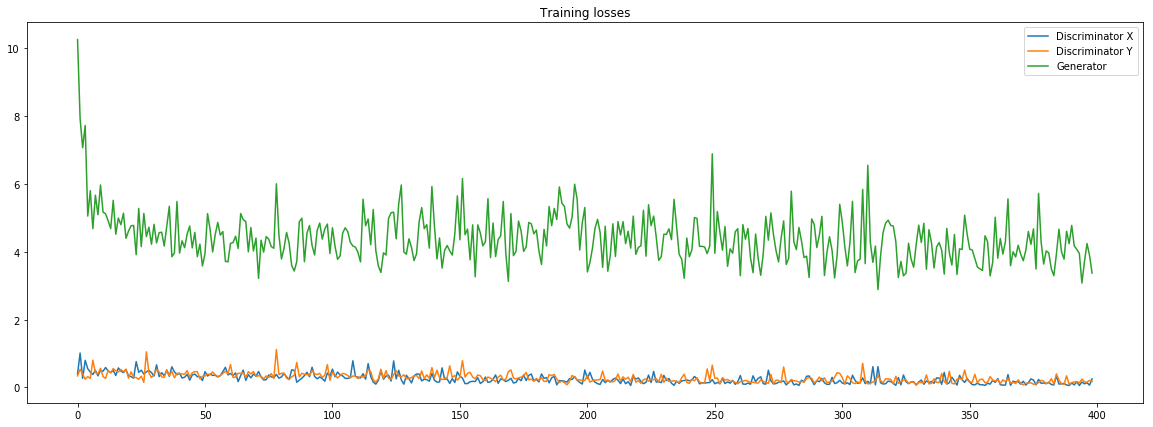

In [23]:
losses = np.array(losses)
plt.figure(figsize=(20, 7))
plt.plot(losses.T[0], label='Discriminator X')
plt.plot(losses.T[1], label='Discriminator Y')
plt.plot(losses.T[2], label='Generator')
plt.title("Training losses")
plt.legend()

0

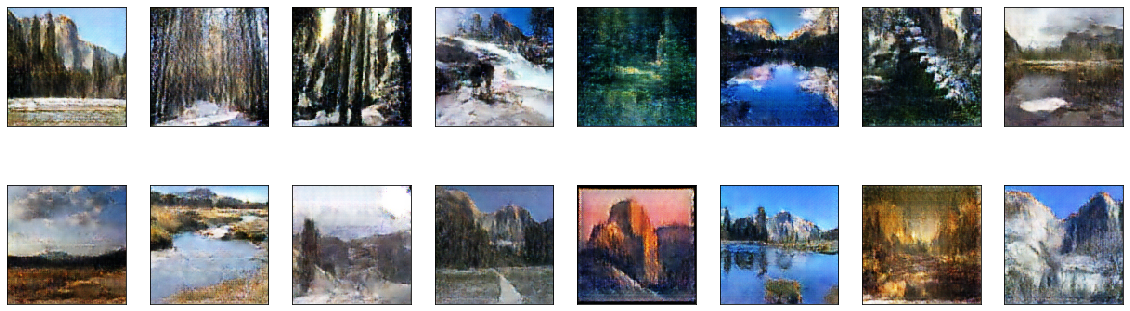

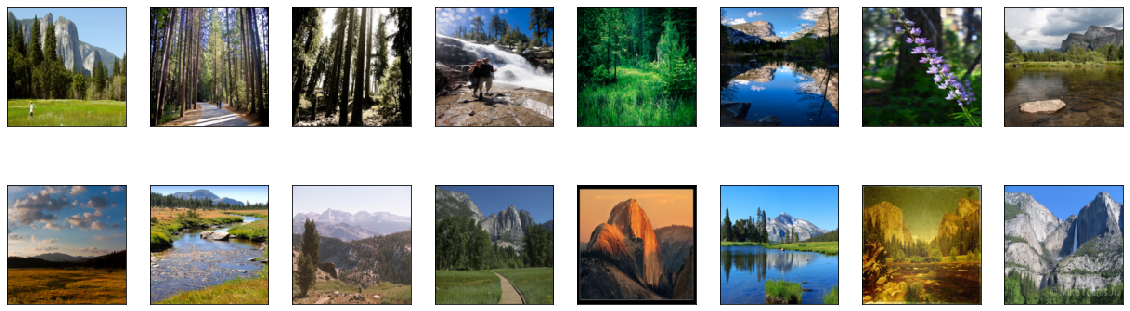

In [24]:
input_X, _ = next(iter(X_trainloader))
input_X = input_X.to(device)
input_Y, _ = next(iter(Y_trainloader))
input_Y = input_Y.to(device)
image_Y = GX_Y(input_X)
image_X = GY_X(input_Y)

def imshow_results(batch_img):
    fig, axes = plt.subplots(2, 8, figsize=(20, 6))
    for ax, img in zip(axes.flatten(), batch_img):
        img = img.cpu()
        img = img.detach().numpy()
        imshow(img, ax)
    return 0 

imshow_results(image_Y)
imshow_results(input_X)

0

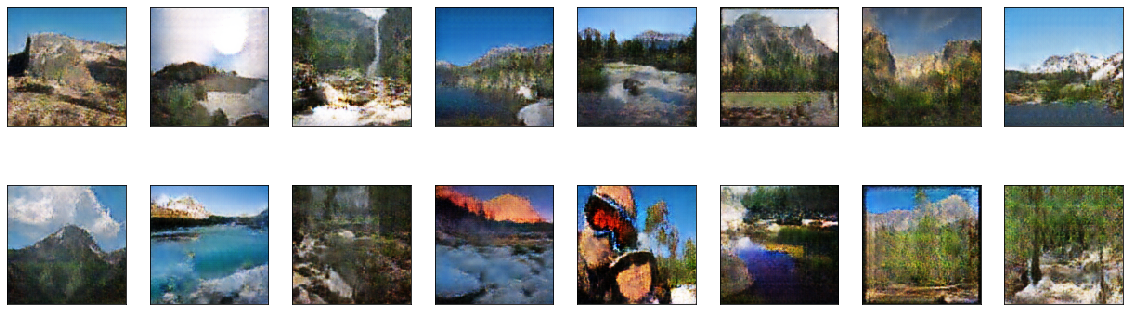

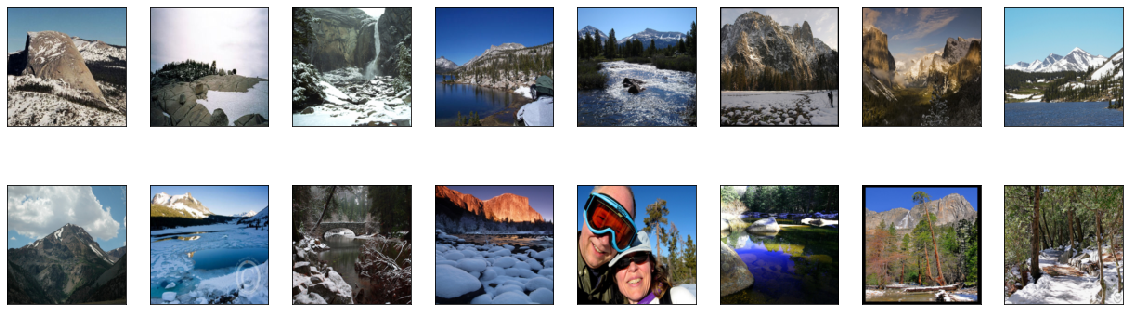

In [25]:
imshow_results(image_X)
imshow_results(input_Y)

In [30]:
def checkpoint(GX_Y, GY_X, D_X, D_Y):
    """Saves the parameters of both generators GX_Y, GY_X and discriminators D_X, D_Y.
        """
    torch.save(GX_Y.state_dict(), 'GX_Y.pkl')
    torch.save(GY_X.state_dict(), 'GY_X.pkl')
    torch.save(D_X.state_dict(), 'D_X.pkl')
    torch.save(D_Y.state_dict(), 'D_Y.pkl')

checkpoint(GX_Y, GY_X, D_X, D_Y)

NameError: name 'G_YtoX' is not defined